<a href="https://colab.research.google.com/github/tngus18/gongboohaeboza/blob/main/ResNet152.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D,MaxPooling2D
from keras.optimizers import Adam
from keras.applications import ResNet152
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 학습 데이터 경로
TRAIN_DIR = '/content/drive/MyDrive/Project/mask_dataset/train/'
# 테스트 데이터 경로
TEST_DIR = '/content/drive/MyDrive/Project/mask_dataset/test/'

In [ ]:
# image 가로/세로 크기
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [ ]:
# 학습에 사용될 이미지 데이터를 읽어오는 객체
# 옵션을 통해 같은 이미지에 변형을 줄 수 있다.
#  -> 적은 양의 데이터로 많은 양의 데이터 효과를 준다.
datagen = ImageDataGenerator(
		rotation_range=180,				# 회전 최대 180도
		width_shift_range=0.2,			# 좌우 이동 최대 이미지 가로사이즈 20%
		height_shift_range=0.2,			# 상하 이동 최대 이미지  세로사이즈 20%
		horizontal_flip=True,			# 좌우 반전 실행
		vertical_flip=True,				# 상하 반전 실행 
		# rescale=1 / 255.0,				# 이미지를 255로 나눠서 0 ~ 1 사이값으로 변환
		brightness_range=[0.5, 1.2],	# 이미지 밝기 조정 -> 0 : 완전 어두운 이미지  1: 원본 밝기
										#  					0.5: 원본 50% 밝기 1.2 : 원본보다 20% 밝은 이미지
		zoom_range=[0.8, 1.2])			# 이미지 확대 0.8: 원본 80% 확대  1.2 : 원본 120% 확대

In [ ]:
train_generator = datagen.flow_from_directory(
		TRAIN_DIR,								# 데이터셋 경로 -> 이미지 경로
		target_size=(IMG_HEIGHT, IMG_WIDTH),	# 이미지의 크기
		batch_size=64,							# 한 번이 반환할 이미지의 개수 설정
		class_mode='categorical',				# 분류 방법 ->  categorical : 다중분류(onehot), binary : 이진분류
												#			   sparse : 다중분류(레이블 encoding)
		shuffle=True)							# 데이터를 섞는다

Found 1652 images belonging to 4 classes.


In [ ]:
test_datagen = ImageDataGenerator()

In [ ]:
test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=64,
        class_mode='categorical',
        shuffle=False)

Found 400 images belonging to 4 classes.


In [ ]:
# image, label을 batch_size만큼 뽑아서 대입
img, label = train_generator.next()

In [ ]:
img.shape, label.shape

((64, 224, 224, 3), (64, 4))

In [ ]:
conv_layers = ResNet152(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

234698864/234698864 [==============================] - 11s 0us/step


In [ ]:
conv_layers.summary()

Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [ ]:
# 이미지넷 대회의 필터를 그대로 사용 
for layer in conv_layers.layers:
    # 해당 레이어의 weight는 수정하지 않고 이미지넷 대회의 값 그대로 사용 
    layer.trainable = False

In [ ]:
model = Sequential()

In [ ]:
model.add(conv_layers)

In [ ]:
model.add(Flatten())

In [ ]:
model.add(Dense(512, activation='relu'))

In [ ]:
model.add(Dropout(0.5))

In [ ]:
model.add(Dense(256, activation='relu'))

In [ ]:
model.add(Dropout(0.5))

In [ ]:
model.add(Dense(4, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-5), metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 1

In [ ]:
cb_checkpoint = ModelCheckpoint(
    filepath="/content/drive/MyDrive",   # 학습 진행시 가장 정확도가 높은 모델을 저장할 경로
    monitor='val_acc',                                                          # 저장할 조건 val_acc (테스트 데이터의 정확도) 가 가장 높은 모델을 저장
    vervose=1,                                                                  # 함수의 진행 과정 출력
    save_best_only=True)   

In [ ]:
history = model.fit(
                train_generator,
                epochs=30,
                validation_data=test_generator,   # 한번 학습이 끝날때 마다 test_generator(테스트 데이터) 로 검증
                callbacks=[cb_checkpoint])        # 학습시 가장 정확도가 높은 모델을 저장하도록 설정

Epoch 1/30
26/26 [==============================] - ETA: 0s - loss: 3.3545 - acc: 0.3172 

26/26 [==============================] - 1270s 49s/step - loss: 3.3545 - acc: 0.3172 - val_loss: 1.1542 - val_acc: 0.5850
Epoch 2/30
26/26 [==============================] - ETA: 0s - loss: 2.1246 - acc: 0.4159

26/26 [==============================] - 107s 4s/step - loss: 2.1246 - acc: 0.4159 - val_loss: 0.8776 - val_acc: 0.6650
Epoch 3/30
26/26 [==============================] - ETA: 0s - loss: 1.6052 - acc: 0.4788

26/26 [==============================] - 107s 4s/step - loss: 1.6052 - acc: 0.4788 - val_loss: 0.8068 - val_acc: 0.6775
Epoch 4/30
26/26 [==============================] - ETA: 0s - loss: 1.4202 - acc: 0.5139

26/26 [==============================] - 108s 4s/step - loss: 1.4202 - acc: 0.5139 - val_loss: 0.8052 - val_acc: 0.6850
Epoch 5/30
26/26 [==============================] - 49s 2s/step - loss: 1.2846 - acc: 0.5375 - val_loss: 0.8171 - val_acc: 0.6850
Epoch 6/30
26/26 [==============================] - ETA: 0s - loss: 1.1798 - acc: 0.5745

26/26 [==============================] - 106s 4s/step - loss: 1.1798 - acc: 0.5745 - val_loss: 0.7931 - val_acc: 0.6875
Epoch 7/30
26/26 [==============================] - ETA: 0s - loss: 1.0876 - acc: 0.5932

26/26 [==============================] - 107s 4s/step - loss: 1.0876 - acc: 0.5932 - val_loss: 0.7727 - val_acc: 0.6950
Epoch 8/30
26/26 [==============================] - 49s 2s/step - loss: 1.0964 - acc: 0.5920 - val_loss: 0.7875 - val_acc: 0.6950
Epoch 9/30
26/26 [==============================] - ETA: 0s - loss: 1.0420 - acc: 0.6096

26/26 [==============================] - 106s 4s/step - loss: 1.0420 - acc: 0.6096 - val_loss: 0.7404 - val_acc: 0.7000
Epoch 10/30
26/26 [==============================] - ETA: 0s - loss: 1.0113 - acc: 0.6084

26/26 [==============================] - 108s 4s/step - loss: 1.0113 - acc: 0.6084 - val_loss: 0.7449 - val_acc: 0.7125
Epoch 11/30
26/26 [==============================] - ETA: 0s - loss: 0.9873 - acc: 0.6192

26/26 [==============================] - 109s 4s/step - loss: 0.9873 - acc: 0.6192 - val_loss: 0.7231 - val_acc: 0.7175
Epoch 12/30
26/26 [==============================] - 48s 2s/step - loss: 0.9195 - acc: 0.6556 - val_loss: 0.7279 - val_acc: 0.7175
Epoch 13/30
26/26 [==============================] - ETA: 0s - loss: 0.9160 - acc: 0.6429

26/26 [==============================] - 106s 4s/step - loss: 0.9160 - acc: 0.6429 - val_loss: 0.6752 - val_acc: 0.7325
Epoch 14/30
26/26 [==============================] - ETA: 0s - loss: 0.8776 - acc: 0.6538

26/26 [==============================] - 106s 4s/step - loss: 0.8776 - acc: 0.6538 - val_loss: 0.6847 - val_acc: 0.7425
Epoch 15/30
26/26 [==============================] - ETA: 0s - loss: 0.8895 - acc: 0.6531

26/26 [==============================] - 107s 4s/step - loss: 0.8895 - acc: 0.6531 - val_loss: 0.6945 - val_acc: 0.7475
Epoch 16/30
26/26 [==============================] - 48s 2s/step - loss: 0.8398 - acc: 0.6780 - val_loss: 0.6891 - val_acc: 0.7475
Epoch 17/30
26/26 [==============================] - 46s 2s/step - loss: 0.8463 - acc: 0.6683 - val_loss: 0.6930 - val_acc: 0.7475
Epoch 18/30
26/26 [==============================] - 46s 2s/step - loss: 0.8026 - acc: 0.6786 - val_loss: 0.7326 - val_acc: 0.7225
Epoch 19/30
26/26 [==============================] - 46s 2s/step - loss: 0.8228 - acc: 0.6828 - val_loss: 0.6821 - val_acc: 0.7400
Epoch 20/30
26/26 [==============================] - 46s 2s/step - loss: 0.8044 - acc: 0.6925 - val_loss: 0.7139 - val_acc: 0.7450
Epoch 21/30
26/26 [==============================] - 46s 2s/step - loss: 0.7785 - acc: 0.6931 - val_loss: 0.7350 - val_acc: 0.7250
Epoch 22/30
26/26 [==============================] - 45s 2s/step - loss: 0.7794 - acc: 0.6961 

26/26 [==============================] - 103s 4s/step - loss: 0.7027 - acc: 0.7288 - val_loss: 0.5875 - val_acc: 0.7750
Epoch 28/30
26/26 [==============================] - 48s 2s/step - loss: 0.7338 - acc: 0.7094 - val_loss: 0.6212 - val_acc: 0.7525
Epoch 29/30
26/26 [==============================] - 47s 2s/step - loss: 0.7292 - acc: 0.7161 - val_loss: 0.6153 - val_acc: 0.7575
Epoch 30/30
26/26 [==============================] - 46s 2s/step - loss: 0.7119 - acc: 0.7349 - val_loss: 0.6149 - val_acc: 0.7700


In [ ]:
best_model = keras.models.load_model("/content/drive/MyDrive")

In [ ]:
best_model.evaluate(test_generator)

7/7 [==============================] - 14s 933ms/step - loss: 0.5875 - acc: 0.7750


[0.5874573588371277, 0.7749999761581421]

In [ ]:
X_test, y_test = test_generator.next()

In [ ]:
predict = best_model.predict(X_test)

2/2 [==============================] - 3s 35ms/step


In [ ]:
predict01 = np.argmax(predict,1)

In [ ]:
target = np.argmax(y_test, 1)

In [ ]:
predict02 = (predict01 == target)

In [ ]:
np.sum(predict02)

36

In [ ]:
acc=np.sum(predict02)/len(predict02)

In [ ]:
train_generator.class_indices.keys()

dict_keys(['etc', 'incorrect_mask', 'with_mask', 'without_mask'])

In [ ]:
custom_labels = list(train_generator.class_indices.keys())

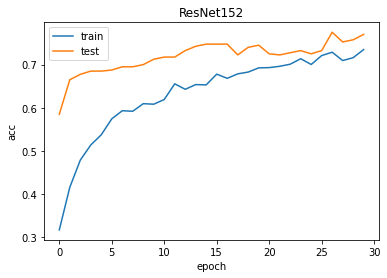

In [ ]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.title('ResNet152')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.show()

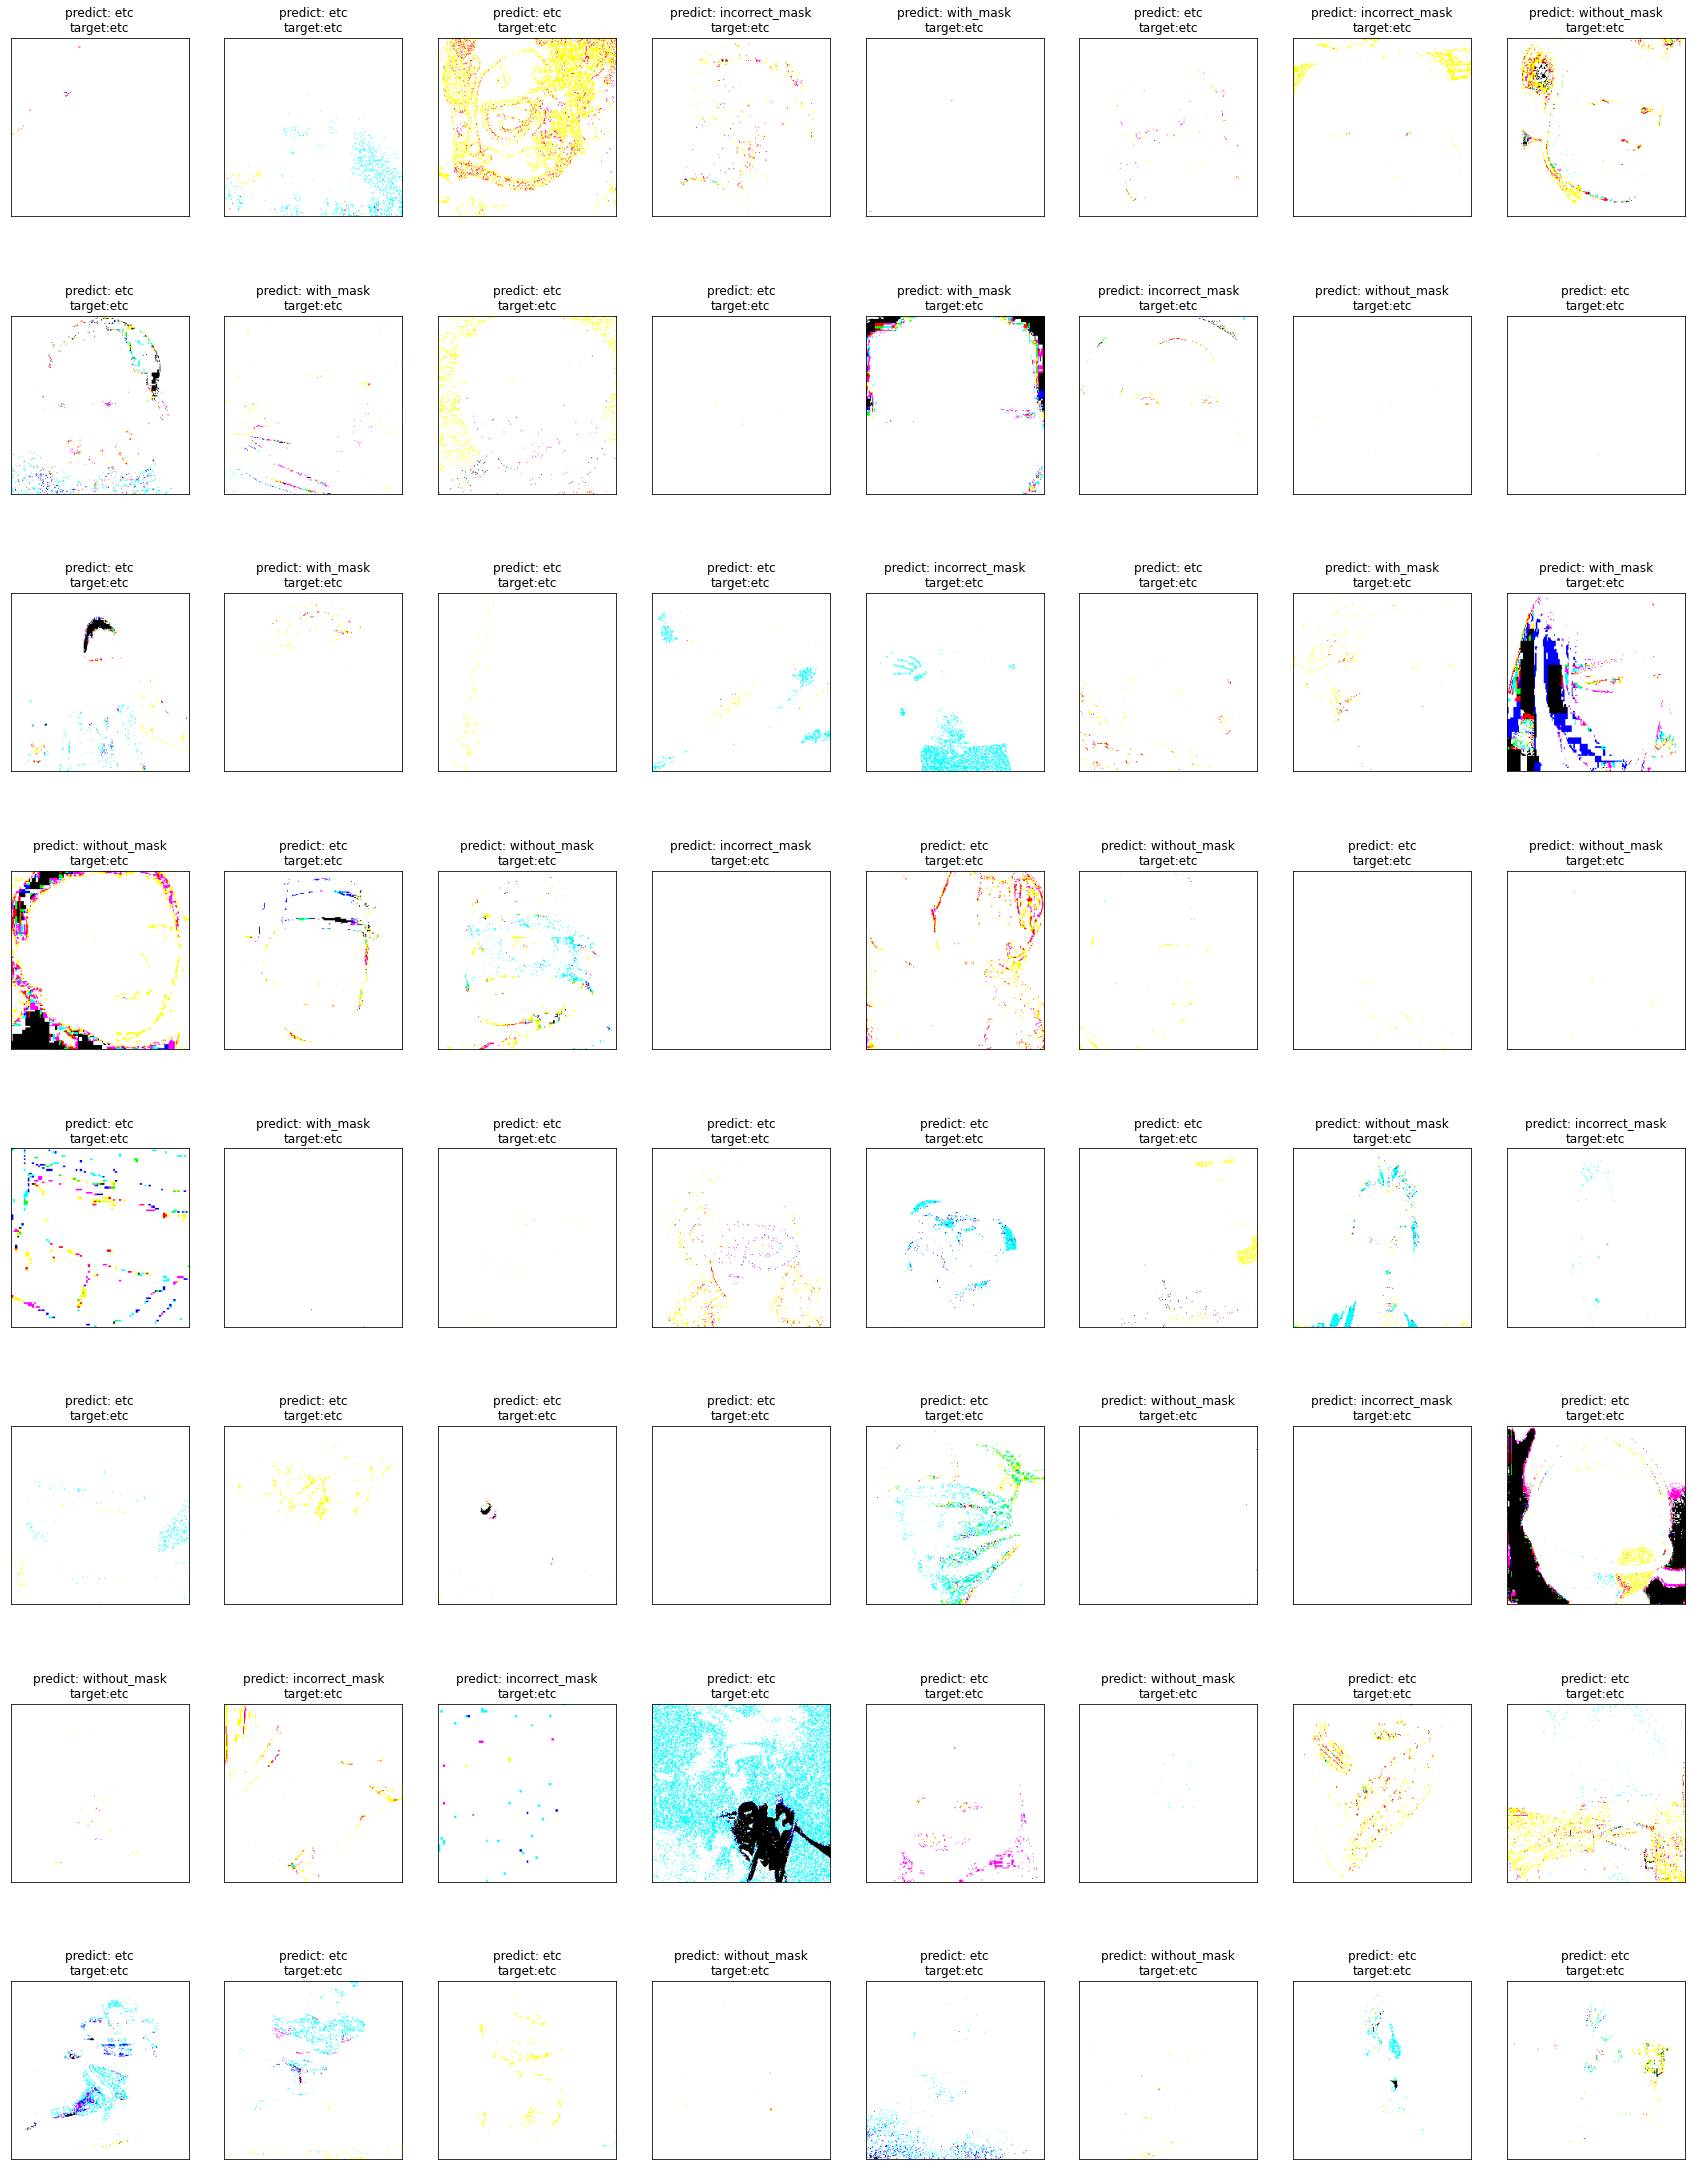

In [ ]:
fig = plt.figure(figsize=(30, 40))
for i in range(64):
    #8줄 8칸으로 나누고 i+1번째 이미지를 그림
    subplot = fig.add_subplot(8, 8, i + 1)
    subplot.set_xticks([])
    subplot.set_yticks([])

    #예측값(숫자)을 predict_num에 대입
    predict_num=predict01[i]
    #예측값에 해당하는 문자를 리턴
    predict_str=custom_labels[predict_num]
    #실제 값(숫자) 리턴
    target_num=target[i]
    #실제 값에 해당하는 문자 리턴
    target_str=custom_labels[target_num]
    
    subplot.set_title('predict: %s\ntarget:%s' % (predict_str,target_str))
    subplot.imshow(X_test[i].reshape((224, 224,3)))
plt.show()